In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyecharts.charts import Pie
import seaborn as sns
sns.set_style('white',{'font.sans-serif':['simhei','Arial']})
pd.set_option("display.max_column", None)
pd.set_option("display.max_row",None)

In [162]:
path = './data/lagou.csv'
df = pd.read_csv(path)
df.isnull().sum()
df.head(1)

,Unnamed: 0,_id,adWord,appShow,approve,businessZones,city,companyFullName,companyId,companyLabelList,companyLogo,companyShortName,companySize,createTime,deliver,district,education,explain,financeStage,firstType,formatCreateTime,gradeDescription,hitags,imState,industryField,industryLables,isHotHire,isSchoolJob,jobNature,lastLogin,latitude,linestaion,longitude,pcShow,plus,positionAdvantage,positionId,positionLables,positionName,promotionScoreExplain,publisherId,resumeProcessDay,resumeProcessRate,salary,score,secondType,skillLables,stationname,subwayline,thirdType,workYear,job_detail
0,0,5de5e75734e608e63026c1bc,9,0,1,['亦庄'],北京,达疆网络科技（上海）有限公司,32836,"['年底双薪', '绩效奖金', '岗位晋升', '定期体检']",i/image2/M01/AF/7F/CgotOV3kqOqAZvWrAAAaonXDCck...,达达-京东到家,2000人以上,2019-12-02 20:38:25,0,大兴区,本科,NaN,D轮及以上,产品|需求|项目类,1天前发布,NaN,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...",today,消费生活,[],0,0,全职,2019-12-03 10:33:07,39.795747,亦庄线_万源街;亦庄线_荣京东街,116.510442,0,NaN,成长快、氛围好、领导好,6638350,"['BI', '数据分析']",数据分析岗,NaN,7855636,1,100,15k-30k,0,数据分析,"['BI', '数据分析']",万源街,亦庄线,BI,3-5年,"1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据..."


In [163]:

columns = ["positionName", "companyShortName", "city", "companySize", "education", "financeStage",
           "industryField", "salary", "workYear", "hitags", "companyLabelList", "job_detail"]
df = df[columns].drop_duplicates() #去重


## 分析目标
- 各城市对数据分析岗位的需求量
- 不同细分领域对数据分析岗位的需求情况
- 薪资状况
- 需要技能
- 学历要求
- 不同规模企业对薪资经验要求以及提供的薪资水平

## 数据预处理

### 过滤掉非数分岗的数据

In [164]:
n = df.shape[0]
print('原始数据共{}条'.format(n))

原始数据共2939条


In [165]:
contain = df['positionName'].str.contains('数据分析')
not_contain = ~df['positionName'].str.contains('实习')

n1 = df[contain & not_contain].shape[0]
print('删除{}条数据'.format(n - n1))
print('剩余{}条数据'.format(n1))

删除1613条数据
剩余1326条数据


In [166]:
df = df[contain & not_contain]
# drop默认删除行, inplace表示在原数据上进行操作
df.drop(['positionName'], axis=1, inplace=True)
# drop=True 不保留原来的index
df.reset_index(drop=True, inplace=True)


### 将薪水转化为数值

将字符串区间如下，转化为均值作为对应薪水

In [167]:
df['salary'].head(5)

0    15k-30k
1    10k-18k
2    20k-30k
3    33k-50k
4    10k-15k
Name: salary, dtype: object

In [168]:
df['salary'] = df['salary'].str.lower().str.extract(r'(\d+)[k]-(\d+)[k]')\
               .applymap(lambda x: int(x)).mean(axis=1)
# applymap 用于df 作用于每一个元素
# map 做用于series 每个元素
# apply 用于df 对row和column计算

### 从job_detail中提取技能要求

技能分为以下几类：
- Python/R
- SQL
- Tableau
- Excel
处理方式：
如果job_detail含有上述，则赋值1，反之赋值0。

In [169]:
df['job_detail'] = df['job_detail'].str.lower().fillna('')
df['Python/R'] = df['job_detail'].map(lambda x: 1 if ('python' in x) or ('r' in x) else 0)
df['SQL'] = df['job_detail'].map(lambda x: 1 if 'sql' in x else 0)
df['Tableau'] = df['job_detail'].map(lambda x: 1 if 'tableau' in x else 0)
df['Excel'] = df['job_detail'].map(lambda x: 1 if 'excel' in x else 0)

In [170]:
df.head(1)

,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail,Python/R,SQL,Tableau,Excel
0,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,22.5,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据...",1,1,0,1


### 处理行业信息

In [171]:
def clean_industry_info(industry):
    industry = industry.split(',')
    if industry[0]=="移动互联网" and len(industry)>1:
        return industry[1]
    else:
        return industry[0]
df["industryField"] = df.industryField.map(clean_industry_info)

In [172]:
df["industryField"].head(5)

0     消费生活
1    移动互联网
2     消费生活
3       电商
4       电商
Name: industryField, dtype: object

## 数据分析

### 各城市对数据分析岗位的需求

In [249]:
from pyecharts.globals import NotebookType,CurrentConfig
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from pyecharts.charts import *
from pyecharts import options as opts

# 得到顺序数据
city = df['city'].value_counts()
city_index = city.index.tolist()
city = city.tolist()

bar = Bar()
bar.add_xaxis(city_index)
bar.add_yaxis('',city)
# 取消标签设置
bar.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
line = Line()
line.add_xaxis(city_index)
line.add_yaxis('',city)
overlap = line.overlap(bar)

overlap.set_global_opts(title_opts=opts.TitleOpts(title = '各城市对数据分析师的需求'))
overlap.load_javascript()
overlap.render_notebook()

D:\Python\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 各 Chart 将在 1.9.0 版本开始强制使用 ChartItem 进行数据项配置
  super().__init__(init_opts=init_opts)
D:\Python\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 各 Chart 将在 1.9.0 版本开始强制使用 ChartItem 进行数据项配置
  super().__init__(init_opts=init_opts)


北上广深四个一线城市对数据分析师的需求量较大。北京上海位列一二，所以想求职数分岗位的可以去一线城市寻求更多的机会。



### 不同领域对数据分析师的需求

In [174]:
industry = df['industryField'].value_counts()[:10]
industry_index = industry.index.tolist()
industry = industry.tolist()


bar = Bar()
bar.add_xaxis(industry_index)
bar.add_yaxis('',industry)
# 取消标签设置
bar.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
line = Line()
line.add_xaxis(industry_index)
line.add_yaxis('',industry)
overlap = line.overlap(bar)

overlap.set_global_opts(title_opts=opts.TitleOpts(title = '不同领域对数据分析师的需求'))
overlap.load_javascript()
overlap.render_notebook()

D:\Python\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 各 Chart 将在 1.9.0 版本开始强制使用 ChartItem 进行数据项配置
  super().__init__(init_opts=init_opts)
D:\Python\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 各 Chart 将在 1.9.0 版本开始强制使用 ChartItem 进行数据项配置
  super().__init__(init_opts=init_opts)


电商、金融和数据服务这三个领域的需求量位列前三位，电商和金融领域的需求远远超过其他领域。其他领域如消费生活、企业服务和文娱业也有不少的机会。

### 各城市薪资状况

Text(0, 0.5, '')

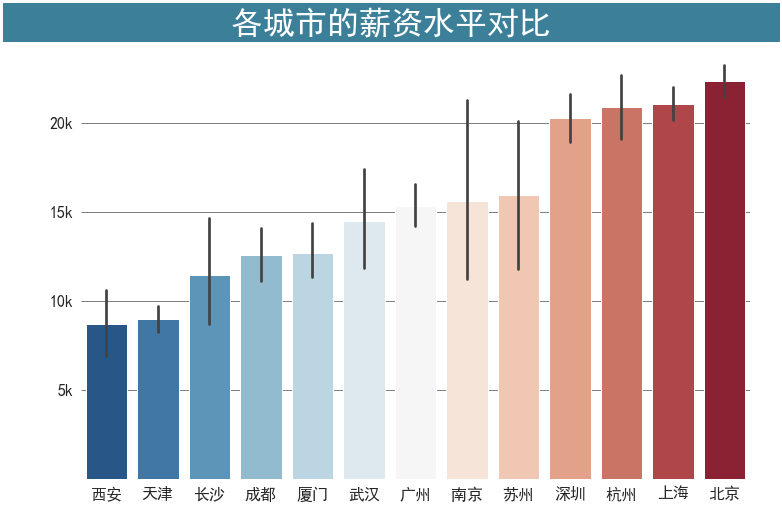

In [175]:
fig,ax = plt.subplots(figsize=(12,8))
city_order = df.groupby("city")["salary"].mean()\
               .sort_values()\
               .index.tolist()
sns.barplot(x="city", y="salary", order=city_order, data=df, ci=95,palette="RdBu_r")
fig.text(x=0.04, y=0.90, s='              各城市的薪资水平对比              ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
plt.tick_params(axis="both",labelsize=16,)
ax.yaxis.grid(which='both', linewidth=0.5, color='black')
ax.set_yticklabels([" ","5k","10k","15k","20k"])
plt.box(False)
plt.xlabel('')
plt.ylabel('')

在平均薪资方面，北京、上海、杭州、深圳均给出20k。但是广州作为需求大的城市，给出的薪资却少于上述四个城市，下面绘出该四个城市的分布图。

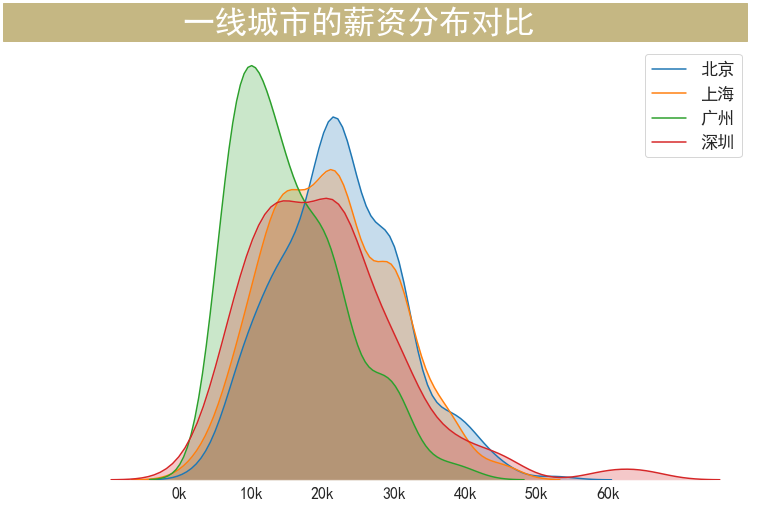

In [176]:
fig,ax = plt.subplots(figsize=(12,8))
fig.text(x=0.04, y=0.90, s='           一线城市的薪资分布对比             ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
sns.kdeplot(df[df["city"]=='北京']["salary"],shade=True,label="北京")
sns.kdeplot(df[df["city"]=='上海']["salary"],shade=True,label="上海")
sns.kdeplot(df[df["city"]=='广州']["salary"],shade=True,label="广州")
sns.kdeplot(df[df["city"]=='深圳']["salary"],shade=True,label="深圳")
plt.tick_params(axis='both', which='major', labelsize=16)
plt.box(False)
plt.xticks(np.arange(0,61,10), [str(i)+"k" for i in range(0,61,10)])
plt.yticks([])
plt.legend(fontsize = 'xx-large',fancybox=None)

从薪资分布来看，深圳和上海的分布较为接近，而广州大多数职位的薪水在10k左右，且分布差异较大。

那会不会是因为广州的招聘信息中，工作经验要求低的岗位占比较高而拉低了整体的薪资水平呢（一般越资深的数据分析师工资会越高）？

### 工作经验与薪水的关系

In [177]:
C_W_S = df.pivot_table(index="city",columns="workYear",values="salary")
C_W_S = C_W_S[["应届毕业生","1-3年","3-5年","5-10年"]]
C_W_S.loc[city_order]

workYear,应届毕业生,1-3年,3-5年,5-10年
city,,,,
西安,12.000000,6.250000,11.000000,NaN
天津,NaN,8.500000,9.000000,NaN
长沙,NaN,10.500000,11.000000,18.250000
成都,10.500000,9.500000,15.833333,18.333333
厦门,10.000000,11.375000,14.400000,NaN
武汉,9.000000,6.666667,17.300000,22.250000
广州,8.727273,10.915094,18.508621,24.800000
南京,12.500000,11.625000,21.000000,NaN
苏州,NaN,10.583333,20.750000,30.000000


(Text(0.5, 51.34375, ''), Text(69.078125, 0.5, ''))

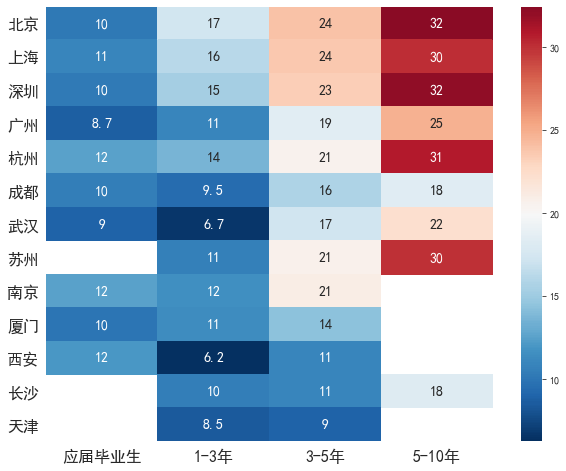

In [178]:
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(C_W_S.loc[df["city"].value_counts().index],cmap="RdBu_r",center=20,annot=True,annot_kws={'fontsize':14})
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16,labelrotation=0)
plt.xlabel(""),plt.ylabel("")

横向来看，随着工作经验的递增，平均的薪资也逐步递增。
纵向来看，不同经验下，广州所给出的平均薪资确实要少于北上深。

### 技术要求

In [259]:
py_rate = df["Python/R"].value_counts(normalize=True).loc[1]
sql_rate = df["SQL"].value_counts(normalize=True).loc[1]
tableau_rate = df["Tableau"].value_counts(normalize=True).loc[1]
excel_rate = df["Excel"].value_counts(normalize=True).loc[1]
print("职位技能需求：")
print("Python/R：",py_rate)
print("SQL：",sql_rate)
print("Excel：",excel_rate)
print("Tableau：",tableau_rate)

data = [tableau_rate, excel_rate, sql_rate, py_rate]
cate = ['Tableau', 'Excel', 'SQL', 'Python/R：']


polar = (
    Polar()
    .add_schema(
        radiusaxis_opts=opts.RadiusAxisOpts(data=cate, type_="category"),
    )
    .add("", data, type_='bar')
    
)

polar.render_notebook()

职位技能需求：
Python/R： 0.6078431372549019
SQL： 0.5897435897435898
Excel： 0.3310708898944193
Tableau： 0.09502262443438914


D:\Python\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 各 Chart 将在 1.9.0 版本开始强制使用 ChartItem 进行数据项配置
  super().__init__(init_opts=init_opts)


要掌握Python/R的公司占到60.8%，和要求SQL的58.97%相接近。有33.1%的公司要求会Excel，要求会Tableau的公司仅占9.5%。这说明，想成为一名合格的数据分析师，Python/R以及SQL得掌握好。

是不是技能要求越高，所对应的薪水就越高呢？

将技能分为:**Excel、SQL、Python/R**,由低到高的顺序，公司要求就取最高的那个。

In [180]:
def get_level(x):
    if x["Python/R"] == 1:
        x["skill"] = "Python/R"
    elif x["SQL"] == 1:
        x["skill"] = "SQL"
    elif x["Excel"] == 1:
        x["skill"] = "Excel"
    else:
        x["skill"] = "其他"
    return x

In [181]:
df = df.apply(get_level,axis=1)

In [182]:
df.head(1)

,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail,Python/R,SQL,Tableau,Excel,skill
0,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,22.5,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据...",1,1,0,1,Python/R


Text(0, 0.5, '技能')

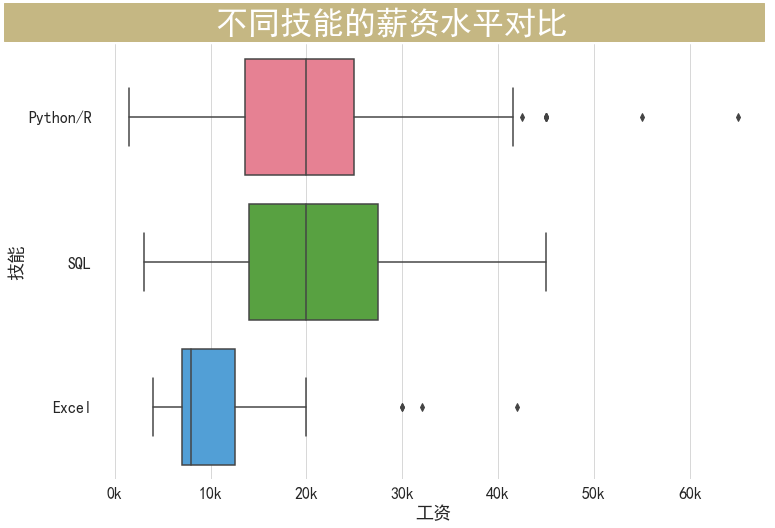

In [183]:
fig,ax = plt.subplots(figsize=(12,8))
fig.text(x=0.02, y=0.90, s='             不同技能的薪资水平对比            ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
sns.boxplot(y="skill",x="salary",data=df.loc[df.skill!="其他"],palette="husl",order=["Python/R","SQL","Excel"])
plt.tick_params(axis="both",labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.75)
plt.xticks(np.arange(0,61,10), [str(i)+"k" for i in range(0,61,10)])
plt.box(False)
plt.xlabel('工资', fontsize=18)
plt.ylabel('技能', fontsize=18)

要求会Python/R和要求会SQL所对应的薪资中位数均为20k，会Python/R并没有比会SQL在薪资上更有优势，但仅要求会Excel的岗位对应的薪资则明显低于前两者。因此，从数据的角度来看，想往数据分析方向走的话，技能方面可以先把SQL掌握了（SQL入门简单但精通并不容易的）。

### 学历要求

In [184]:
education = df["education"].value_counts(normalize=True)

In [185]:
from pyecharts.commons.utils import JsCode
def new_label_opts():
        return opts.LabelOpts(formatter=JsCode("学历要求"))
pie = (
    Pie()
    .add(
        "",
        [list(z) for z in zip(education.index, np.round(education.values,4))],
        center=["50%", "50%"],
        radius=["50%","75%"],
        label_opts=new_label_opts()
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title=""),
        legend_opts=opts.LegendOpts(
                is_show=False
            )
    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%")))

D:\Python\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 各 Chart 将在 1.9.0 版本开始强制使用 ChartItem 进行数据项配置
  super().__init__(init_opts=init_opts)


In [186]:
pie.render_notebook()

探讨一下，学历和薪资的关系

Text(0, 0.5, '技能')

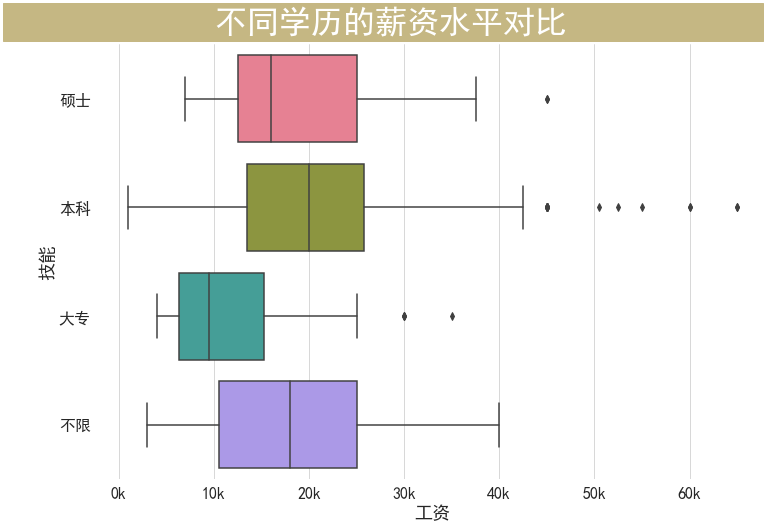

In [187]:
fig,ax = plt.subplots(figsize=(12,8))
fig.text(x=0.02, y=0.90, s='             不同学历的薪资水平对比            ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
sns.boxplot(y="education",x="salary",data=df,palette="husl",order=["硕士","本科","大专", '不限'])
plt.tick_params(axis="both",labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.75)
plt.xticks(np.arange(0,61,10), [str(i)+"k" for i in range(0,61,10)])
plt.box(False)
plt.xlabel('工资', fontsize=18)
plt.ylabel('技能', fontsize=18)

从学历方面，并不能看出硕士学位对薪资的显著提升，可能是由于样本量偏少，但是其变化的波动要小于本科学位的薪资，说明硕士学位占据一定的优势。

再来探讨一下，不同城市对学历的要求

In [188]:
C_E_S = df.pivot_table(index="city",columns="education",values="salary")
C_E_S


education,不限,大专,本科,硕士
city,,,,
上海,17.220000,14.388889,21.681004,20.433333
北京,20.800000,17.083333,22.803630,18.461538
南京,15.000000,NaN,15.772727,NaN
厦门,12.000000,9.000000,13.250000,12.500000
天津,NaN,9.000000,9.000000,NaN
广州,19.041667,8.825000,16.019380,16.000000
成都,13.500000,7.500000,13.093750,8.000000
杭州,23.125000,16.333333,21.280899,18.666667
武汉,NaN,5.500000,16.571429,10.750000


(Text(0.5, 51.640625, ''), Text(69.078125, 0.5, ''))

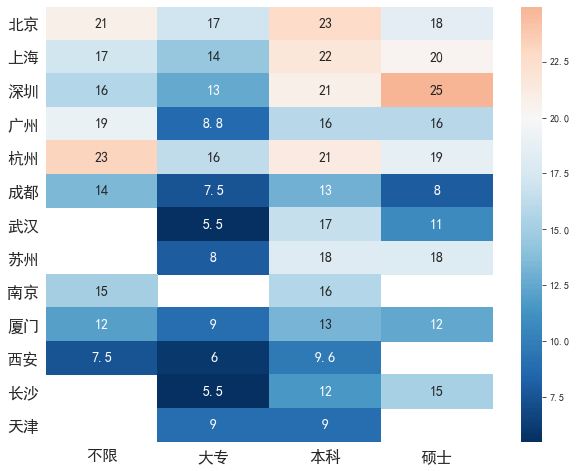

In [189]:
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(C_E_S.loc[df["city"].value_counts().index],cmap="RdBu_r",center=20,annot=True,annot_kws={'fontsize':14})
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16,labelrotation=0)
plt.xlabel(""),plt.ylabel("")

可以看出学历确实影响着薪资水平，随着学历提高，薪资也在提高。

回到广州的问题上，在不同的学历情况下，纵向比较，确实要少于北上深。

### 不同规模公司在招人要求上的差异

求职时，我们选择大公司还是小公司呢？

进大公司又对我们有哪些要求？

为了进一步分析，我们将公司规模、经验要求以及薪资信息绘制到散点图上。

In [241]:
# 设置公司规模标签
company_size_map = {
    "2000人以上": 6,
    "500-2000人": 5,
    "150-500人": 4,
    "50-150人": 3,
    "15-50人": 2,
    "少于15人": 1
}
# 设置工作经验标签
workYear_map = {
    "5-10年": 5,
    "3-5年": 4,
    "1-3年": 3,
    "1年以下": 2,
    "应届毕业生": 1
}
# 
df["company_size"] = df["companySize"].map(company_size_map)
df["work_year"] = df["workYear"].map(workYear_map)

In [242]:
# 升序排列
df = df.sort_values(by="company_size",ascending=True)

In [243]:
# 找出工作经验不为空
df_plot = df.loc[~df.work_year.isna()]

In [244]:
color_map = {
    5:"#ff0000",
    4:"#ffa500",
    3:"#c5b783",
    2:"#3c7f99",
    1:"#0000cd"
}
df_plot.loc[:,"color"] = df_plot.work_year.map(color_map)
df_plot.reset_index(drop=True,inplace=True)

D:\Python\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Python\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [247]:
def seed_scale_plot():
    seeds = np.arange(1, 6)
    y = np.zeros(len(seeds),dtype=int)
    s = seeds * 100
    colors = ['#ff0000', '#ffa500', '#c5b783', '#3c7f99', '#0000cd'][::-1]
#     colors = sns.color_palette("husl", n_colors=6)  
    fig,ax = plt.subplots(figsize=(12,1))
    plt.scatter(seeds,y,s=s,c=colors,alpha=0.3)
    plt.scatter(seeds,y,c=colors)
    plt.box(False)
    plt.grid(False)
    plt.xticks(ticks=seeds,labels=list(workYear_map.keys())[::-1],fontsize=14)
    plt.yticks(np.arange(1),labels=['  经验：'],fontsize=16)

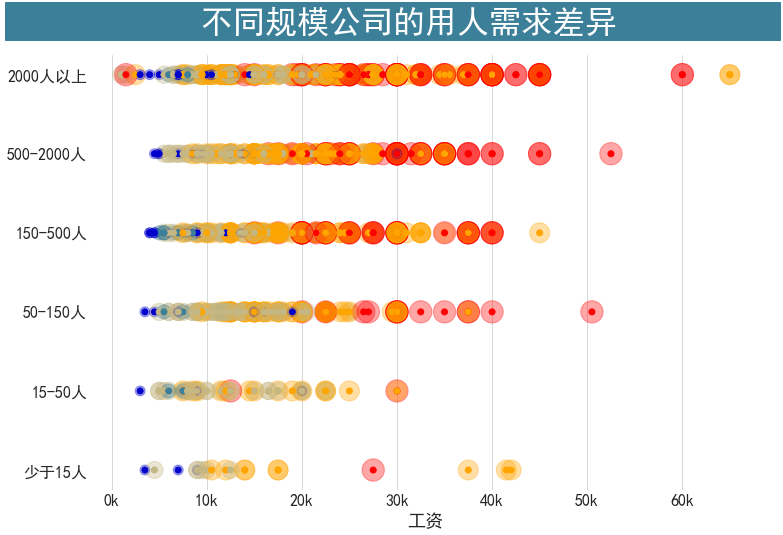

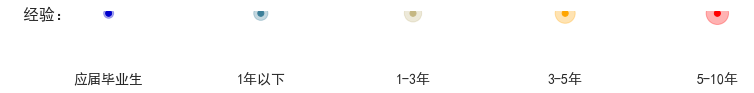

In [246]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.text(x=0.03, y=0.92, s='            不同规模公司的用人需求差异          ', fontsize=32, 
         weight='bold', color='white', backgroundcolor='#3c7f99')
plt.scatter(df_plot.salary, df_plot["companySize"],  s=df_plot["work_year"] * 100 ,alpha=0.35, c=df_plot["color"].tolist())
plt.scatter(df_plot.salary, df_plot["companySize"], c=df_plot["color"])
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.75)
plt.xticks(np.arange(0,61,10), [str(i)+"k" for i in range(0,61,10)])
plt.xlabel('工资', fontsize=18)
plt.box(False)
seed_scale_plot()

对小公司（50人及以下）而言，大部分公司开出的薪资不会超过30k，规模更大的公司开的起更高的薪水，即便是对于一些工作经验不到1年的数据分析师，规模稍大的公司也能开出20k-30k的薪水，所以如果从面向工资编程的角度看，大公司具有较为明显的优势。另一方面，从图中可以看到，当薪水超过30k时，公司对数据分析师的经验要求大多都是3-5年以及5-10年，此时经验成为了较大的门槛。接下来看看大公司在技能方面的要求，这里定义2000人以上的公司为大公司。

In [197]:
df_skill = df.loc[(df["companySize"]=="2000人以上")&(df.skill!="其他")]["skill"].value_counts(normalize=True)

In [ ]:
df_skill = round(df_skill, 2)

In [ ]:
bar = Bar()
bar.add_xaxis(df_skill.index.tolist())
bar.add_yaxis('',df_skill.tolist())
bar.set_global_opts(title_opts=opts.TitleOpts(title = '大公司对技能的要求占比'))
bar.load_javascript()
bar.render_notebook()

76%的大公司对岗位要求掌握python/R，如果想进大公司，也必须要把Python/R掌握到位。

## 综上所述：
- 一线城市北上广深对数据分析师的需求量较大
- 电商、金融领域的相对需求较大
- 北京、上海、杭州、深圳给出的薪资平均为20K，为第一梯队
- 广州作为一线城市，给出的薪资并没有相对优势
- 技能掌握Python，并且具有学历上的优势，会较容易取得高薪，但绝大部分学历要求本科即可。
- 如果想进大厂，最好掌握Python。

In [266]:
## 综上所述：
- 一线城市北上广深对数据分析师的需求量较大
- 电商、金融领域的相对需求较大
- 北京、上海、杭州、深圳给出的薪资平均为20K，为第一梯队
- 广州作为一线城市，给出的薪资并没有相对优势
- 技能掌握Python，并且具有学历上的优势，会较容易取得高薪，但绝大部分学历要求本科即可。
- 如果想进大厂，最好掌握Python。

In [267]:
bar = Bar()
bar.add_xaxis(df_skill.index.tolist())
bar.add_yaxis('',df_skill.tolist())
bar.set_global_opts(title_opts=opts.TitleOpts(title = '大公司对技能的要求占比'))
bar.load_javascript()
bar.render_notebook()

D:\Python\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 各 Chart 将在 1.9.0 版本开始强制使用 ChartItem 进行数据项配置
  super().__init__(init_opts=init_opts)


76%的大公司对岗位要求掌握python/R，如果想进大公司，也必须要把Python/R掌握到位。

## 综上所述：
- 一线城市北上广深对数据分析师的需求量较大
- 电商、金融领域的相对需求较大
- 北京、上海、杭州、深圳给出的薪资平均为20K，为第一梯队
- 广州作为一线城市，给出的薪资并没有相对优势
- 技能掌握Python，并且具有学历上的优势，会较容易取得高薪，但绝大部分学历要求本科即可。
- 如果想进大厂，最好掌握Python。